## Trait-management performance
Quantifying performance of different trait combinations in terms of __yield__ & __yield variance__

In [107]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlGnBu_9
from palettable.colorbrewer.sequential import BuGn_6

from palettable.cmocean.sequential import Tempo_10
from palettable.cartocolors.qualitative import Vivid_5
from palettable.colorbrewer.qualitative import Set2_5

from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype.utils import custom_colormap, fold
from ideotype.init_params import params_sample

In [2]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_present.yml')
df_extended, df_stuck = parse_mature(df_all)

### High performing trait-management combination for each site

Text(0.5, 1.0, 'varaince across years averaged over all sites')

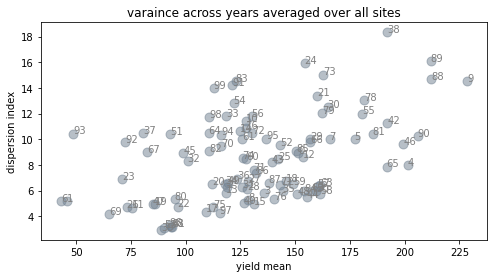

In [3]:
# yield variance across site & years
yield_mean = df_all.groupby('cvar').mean().dm_ear
yield_variance = df_all.groupby('cvar').var().dm_ear
yield_disp = yield_variance/yield_mean

# visulization
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
sc = ax.scatter(yield_mean, yield_variance/yield_mean, c='slategrey', s=80, alpha=0.5)
for i in np.arange(100):
    ax.annotate(i, (yield_mean[i], yield_variance[i]/yield_mean[i]), c='grey')
    
ax.set_xlabel('yield mean')
ax.set_ylabel('dispersion index')
ax.set_title('varaince across years averaged over all sites')
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/varstd_acrossyears.png', format='png', dpi=800)

### Identify top performing trait-management combinations

In [39]:
# Set up sites
sites = sorted(list(set(df_all.site)))
phenos = list(set(df_all.cvar))

# Parameters
n_pheno = 5
list_top_phenos = [[] for item in np.arange(n_pheno)]
w_yield = 0.7  # weight yield & dispersion importance
w_disp = 0.5

# Identify high performing combinations
for site in sites:
    # Filter out data for specific site
    df_sub = df_all.query(f'site=="{site}"')
    
    # Calculate mean yied and yield dispersion acorss years for specified site
    yield_mean = df_sub.groupby('cvar').mean().dm_ear
    yield_var = df_sub.groupby('cvar').var().dm_ear
    yiled_disp = yield_mean/yield_var
    
    # Standardize yield_mean & yield_disp into between 0 & 1
    yield_mean_norm = (yield_mean-yield_mean.min())/(yield_mean.max()-yield_mean.min())
    yield_disp_norm = (yield_disp-yield_disp.min())/(yield_disp.max()-yield_disp.min())
    
    # Convert into dataframe
    df_yield_mean = pd.DataFrame(yield_mean_norm)
    df_yield_disp = pd.DataFrame(yield_disp_norm)
    
    # Identify max yield and min dispersion
    max_yield = yield_mean_norm.max()
    min_disp = yield_disp_norm.min()

    # Calculate distance to theoretical optimal
    dist = [np.sqrt(w_yield*(ymean - max_yield)**2 + w_disp*(ydisp - min_disp)**2) for ymean, ydisp in zip(yield_mean_norm, yield_disp_norm)]
    df_dist = pd.DataFrame(dist, columns=['dist'])
    top_phenos = list(df_dist.nsmallest(n_pheno, 'dist').index)
        
    for item in np.arange(len(list_top_phenos)):
        top_pheno = top_phenos[item]
        list_top_phenos[item].append(top_pheno)

# Set up dataframe with top performing pheno info
df_pheno = pd.DataFrame(list_top_phenos).transpose()
df_pheno.columns = [f'pheno{n+1}' for n in np.arange(n_pheno)]
df_pheno['sites'] = sites
df_pheno = pd.merge(df_pheno, df_sites, left_on='sites', right_on='site')

df_sites_sorted = pd.DataFrame(sites)
df_sites_sorted.columns = ['site']
df_sites_sorted['site_num'] = np.arange(len(sites))
df_pheno = pd.merge(df_pheno, df_sites_sorted, left_on='sites', right_on='site')

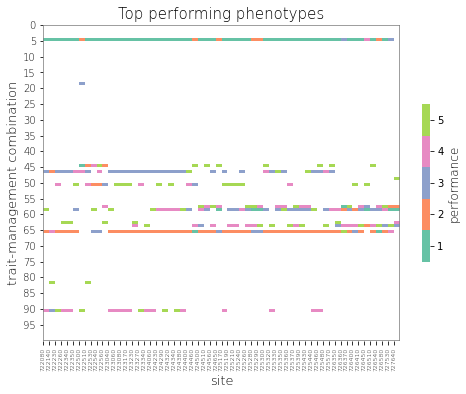

In [43]:
# Initiate empty matrix
mx = np.empty(shape=[len(phenos), len(sites)])
mx[:] = np.nan

# Fill in matrix data
for item in np.arange(n_pheno):
    mx[df_pheno[f'pheno{item+1}'], df_pheno['site_num']] = item + 1

# Visualization
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
cmap = sns.color_palette('Set2', n_pheno) 
hmap = sns.heatmap(mx, cmap=cmap, cbar_kws={'shrink': 0.5},)
hmap.axhline(y = 0, color='grey',linewidth=1.5)
hmap.axhline(y = mx.shape[0], color='grey', linewidth=1.5)
hmap.axvline(x = 0, color='grey', linewidth=1.5)
hmap.axvline(x = mx.shape[1], color='grey', linewidth=1.5)

colorbar = ax.collections[0].colorbar 
c_range = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + c_range / n_pheno * (0.5 + item) for item in range(n_pheno)])
colorbar.set_ticklabels(['1','2','3','4','5'])    

ax.set_title('Top performing phenotypes', fontweight='light', size=15)
ax.set_xlabel('site', fontweight='light', size=13)
ax.set_ylabel('trait-management combination', fontweight='light', size=13)
ax.figure.axes[-1].set_ylabel('performance', size=12, fontweight='light')

plt.xticks(np.arange(len(sites)))
plt.yticks(np.arange(0, len(phenos), 5))
ax.set_xticklabels(sites, fontsize=6, fontweight='light', rotation=90)
ax.set_yticklabels(np.arange(0, len(phenos), 5), fontsize=10, fontweight='light', rotation=0)

fig.subplots_adjust(bottom=0.15)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_topchoice.png', format='png', dpi=800)

### Param values for high performing phenotypes

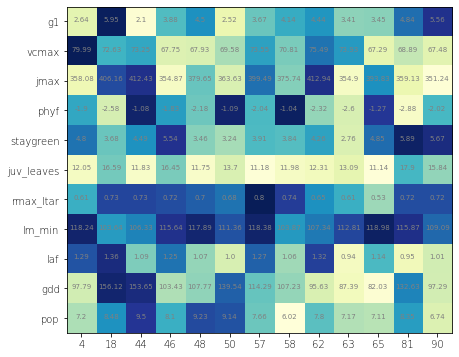

In [138]:
# Set number of top performing phenos
n_pheno = 5

# Determine high-performing phenotypes
list_top_pheno = []
for item in np.arange(n_pheno):
    top_pheno = list(set(df_pheno.iloc[:,item]))
    list_top_pheno.extend(top_pheno)
list_top_pheno = list(set(list_top_pheno))
top_pheno_sorted = sorted(list_top_pheno)

# Determined parameters perturbed and perturb range
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

# Normalize parameter values
df_highperformance = df_params.iloc[top_pheno_sorted, :-1]
for param in params:
    df_params_fold[param] = fold(df_highperformance[param],
                                 param_range[param][0],
                                 param_range[param][1])

# Visualize
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(df_params_fold.transpose(), cmap=YlGnBu_9.mpl_colormap)
ax.set_xticks(np.arange(df_highperformance.shape[0]))
ax.set_yticks(np.arange(df_highperformance.shape[1]))
ax.set_xticklabels(list(df_highperformance.index), size=10, fontweight='light')
ax.set_yticklabels(list(df_highperformance.columns), size=10, fontweight='light')

for top_pheno in range(len(top_pheno_sorted)):
    for param in range(len(params)):
        text = ax.text(top_pheno, param,
                       df_params.transpose().loc[params[param],
                                                 top_pheno_sorted[top_pheno]],
                       ha='center', color='grey', size=7)
fig.subplots_adjust(left=0.15)


### Project onto map

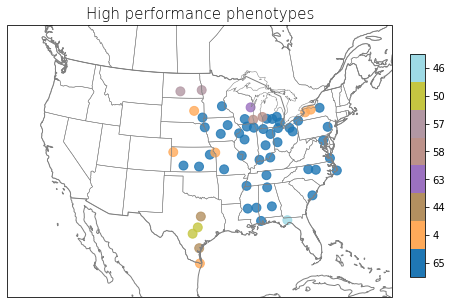

In [9]:
# Phenotype performance rank
pheno = 'pheno2'

# Factorize pheno number
color_list = list(pd.factorize(df_pheno[pheno])[0])

# Set up customized colormap
num_colors = len(set(color_list))
custom_cmap, bounds, norm = custom_colormap(num_colors)

# Visualization
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
mp = ax.scatter(df_pheno.lon, df_pheno.lat, transform=ccrs.PlateCarree(),
                c=color_list, cmap=custom_cmap, alpha=0.8, s=80)
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('High performance phenotypes', fontweight='light', size=15)

ax2 = fig.add_axes([0.93, 0.18, 0.03, 0.62])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=custom_cmap, norm=norm,
                               spacing='proportional', ticks=bounds, boundaries=bounds)
c_range = cb.vmax - cb.vmin 
cb.set_ticks([cb.vmin + c_range / num_colors * (0.5 + item) for item in range(num_colors)])
cb.set_ticklabels(list(pd.factorize(df_pheno[pheno])[1]))

### High performing phenotypes in climate space
Should try some version of PCA on this data

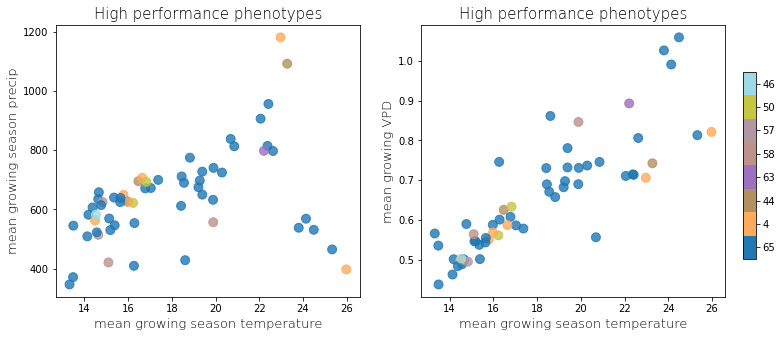

In [11]:
# Phenotype performance rank
pheno = 'pheno2'

# Factorize pheno number
color_list = list(pd.factorize(df_pheno[pheno])[0])

# Set up customized colormap
num_colors = len(set(color_list))
custom_cmap, bounds, norm = custom_colormap(num_colors)

# Climate
site_temps = df_all.groupby('site').mean().temp
site_vpds = df_all.groupby('site').mean().vpd
site_precips = df_all.groupby('site').mean().precip

# Visualization
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
sc1 = ax1.scatter(site_temps, site_precips, c=color_list, cmap=custom_cmap, s=80, alpha=0.8)
ax1.set_title('High performance phenotypes', fontweight='light', size=15)
ax1.set_xlabel('mean growing season temperature', fontweight='light', size=13)
ax1.set_ylabel('mean growing season precip', fontweight='light', size=13)

ax2 = fig.add_subplot(1,2,2)
sc2 = ax2.scatter(site_temps, site_vpds, c=color_list, cmap=custom_cmap, s=80, alpha=0.8)
ax2.set_title('High performance phenotypes', fontweight='light', size=15)
ax2.set_xlabel('mean growing season temperature', fontweight='light', size=13)
ax2.set_ylabel('mean growing VPD', fontweight='light', size=13)

# Custom colorbar for qualitative data
ax2 = fig.add_axes([0.92, 0.23, 0.015, 0.52])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=custom_cmap, norm=norm,
                               spacing='proportional', ticks=bounds, boundaries=bounds)
c_range = cb.vmax - cb.vmin 
cb.set_ticks([cb.vmin + c_range / num_colors * (0.5 + item) for item in range(num_colors)])
cb.set_ticklabels(list(pd.factorize(df_pheno[pheno])[1]))

### Mean yield impact from top 5 high-yielding phenotype for each site
Average positive yield impact from adopting the top 5 identified phenotypes for each location

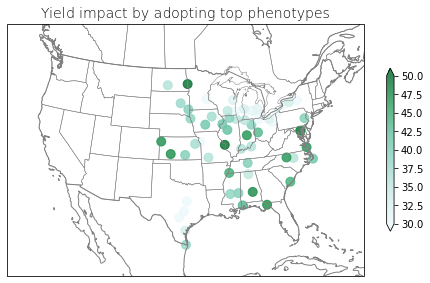

In [132]:
# Read in sims from control runs
df_sims_control, df_sites_control, df_wea_control, df_params_control, df_all_control, df_matured_control = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_control_dympd.yml')

# Calculate mean yield for each site
default_pheno_yields = list(df_matured_control.groupby('site').mean().dm_ear)

# Identify top phenotypes for each site
top_phenos_yields = []
for item, site in enumerate(sites):
    df_site_phenos = pd.DataFrame(mx).iloc[:,item]
    phenos = list(df_site_phenos[df_site_phenos.notnull()].index.values)
    top_phenos_yield = df_matured[
        (df_matured.cvar.isin(phenos)) & (df_matured.site == site)].dm_ear.mean().round(2)
    top_phenos_yields.append(top_phenos_yield)

# Calculate yield impact by adopting top phenotype for each site
yield_impacts = []
for count, site in enumerate(sites):
    yield_impact = ((top_phenos_yields[count]-default_pheno_yields[count])/default_pheno_yields[count])*100
    yield_impacts.append(yield_impact)

# Visualization
fig = plt.figure(figsize=(8,6))
extent = [-123, -72, 19, 53]

ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))

ax.set_extent(extent)
mp = ax.scatter(df_sites.lon, df_sites.lat, transform = ccrs.PlateCarree(),
                c=yield_impacts, cmap=BuGn_6.mpl_colormap, s=80, alpha=0.8,
                vmin=30, vmax=50)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

ax.set_title('Yield impact by adopting top phenotypes', fontweight='light', fontsize=14)
fig.colorbar(mp, shrink=0.5, extend='both')